In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as constants
from forschungspraktikum.functions import langevin, grad_langevin

# Skalares Jiles-Atherton-Modell

Das Jiles-Atherton-Modell ist eines der meistverwendeten Modelle für ferromagnetische Hysterese.

Die konstituierenden Gleichungen sind physikalisch motiviert -- das Modell weist dennoch einige physikalische Unschlüssigkeiten auf. Nichtsdestotrotz findet es vielfache Anwendung, da es die Messdaten relativ gut reproduziert.

## Anhysterische Kennlinie

Für die anhystereische Kennlinie (Wendepunkte bei symmetrischer Aussteuerung) wird eine Langevin-Funktion verwendet:

\begin{equation}
    M_\text{an} = M_\text{sat} \mathrm{L}\left(\frac{H_\text{e}}{a}\right),
\end{equation}

mit $L(x) = \coth(x)-\frac{1}{x}$, den Modellparameteren $a$ und $M_\text{sat}$ und dem effektiven Feld $H_\text{e} := H + \alpha M$, wobei $\alpha$ ein weiterer Modellparameter ist.

## Pinning

Die Hysterese in magnetischen Materialien wird überwiegend über das Pinning erklärt: Die Verschiebung der Blochwände geschieht nicht linear, sondern wird durch Defekte in der Kristallstruktur an manchen Punkten aufgehalten. Dies ist das sogenannte Pinning. Ist ein „Pin” überwunden, zählt die dadurch entstande Magnetisierung zur irreversiblen Magnetisierung, sonst ist sie noch reversibel.

Das Pinning wird durch den Pinning-Faktor $k$ modelliert, die Änderung der irreversiblen Magnetisierung pro Änderung des effektiven Feldes ist

$$ \frac{dM_\text{irr}}{dH_\text{e}} = \frac{M_\text{an} - M_\text{irr}}{k \mathop{\mathrm{sgn}}\left(\frac{dH}{dt}\right)} $$

Die „Richtung” des Pinningeffektes ist dabei von der Änderung des äußeren Feldes abhängig, er wirkt immer dem äußeren Feld entgegen.

## Reversible und irreversible Magnetisierung

Die gesamte Magnetisierung besteht aus einem reversiblen und einem irreversiblen Teil:

$$ M = M_\text{rev} + M_\text{irr}, $$

dabei wird der reversible Anteil durch die Abweichung der irreversiblen Magnetisierung von der anhysterischen Kennlinie beschrieben,

$$ M_\text{irr} = c(M_\text{an} - M_\text{irr}). $$
    
Es folgt somit

$$ M = (1 - c) M_\text{irr} + c M_\text{an}. $$        

## Differentielle Magnetisierung

Mit den vorgestellten Gleichungen und dem Materialgleichung der makroskopischen Maxwellgleichungen

$$ B = \mu_0 (H + M) $$

lässt sich nun die differentielle Magnetisierung ermitteln:

\begin{align}
dM &= (1-c)\ dM_\text{irr} + c\ dM_\text{an}, \\
dM_\text{irr} &= \frac{dM_\text{irr}}{dH_\text{e}}\ dH_\text{e}, \\
dM_\text{an} &= \frac{M_\text{sat}}{a} \frac{d\mathop{\mathrm{L}}(H_\text{e}/a)}{d(H_e/a)} dH_\text{e}, \\
dH_\text{e} &= dH + \alpha\ dM\\
&= \frac{dB}{\mu_0} - (1 - \alpha)\ dM
\end{align}

und somit

$$ dM = \left((1-c)\frac{dM_\text{irr}}{dH_\text{e}} + c\frac{dM_\text{an}}{dH_\text{e}}\right)dH_\text{e} = \frac{dM}{dH_\text{e}}dH_\text{e}.$$

Man kann nun - abhängig von der Beschreibung des elektrodynamischen Problems - verschiedene Varianten entwickeln:

$$ dM = \frac{dM}{dH_\text{e}}(dH + \alpha\ dM) \Rightarrow \frac{dM}{dH} = \frac{\frac{dM}{dH_\text{e}}}{1-\alpha \frac{dM}{dH_\text{e}}} dH$$

oder

$$ dM = \frac{dM}{dH_\text{e}}\left(\frac{dB}{\mu_0} - (1 - \alpha)\ dM\right) \Rightarrow \frac{dM}{dB} = \frac{1}{\mu_0}\frac{\frac{dM}{dH_\text{e}}}{1 + (1 - \alpha)\frac{dM}{dH_\text{e}}}$$


In [4]:
# Naturkonstanten
mu0 = constants.mu_0

# Modellvariablen
alpha = 0.0021
a = 110.5
k = 30.0
c = 0.4
Msat = 1.35e5

In [5]:
def dM_dHe(H, M, H_, M_):
    delta = np.sign(H - H_)
    He = H + alpha * M
    Man = Msat * langevin(He/a)
    Mirr = (M - c * Man)/(1.0 - c)
    dMirr_dHe = (Man - Mirr)/(k*delta)
    dMan_dHe = Msat/a*grad_langevin(He/a)
    dMdHe = (1 - c)*dMirr_dHe + c*dMan_dHe
    return dMdHe

def dM_dH(H, M, H_, M_):
    dMdHe = dM_dHe(H, M, H_, M_)
    x = dMdHe/(1 - alpha * dMdHe)
    return x

def dM_dB(B, M, B_, M_):
    H = B/mu0 - M
    H_ = B_/mu0 - M_
    
    dMdHe = dM_dHe(H, M, H_, M_)
    return 1/mu0 * dMdHe/(1 + (1 - alpha) * dMdHe)

In [6]:
dt = 0.001
T = 10*np.pi

t = np.arange(0, T, dt)
H = 100*np.sin(t)
M = np.zeros(len(t))

## Einfachster numerischer Ansatz: Explizites Eulerverfahren

In [7]:
for i in range(2, len(t) - 1):
    M[i + 1] = dM_dH(H[i], M[i], H[i-1], M[i-1])*(H[i+1] - H[i]) + M[i]

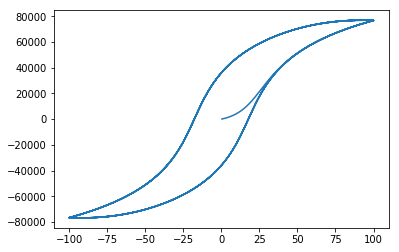

In [8]:
plt.plot(H[4:], (H+M)[4:])
plt.show()

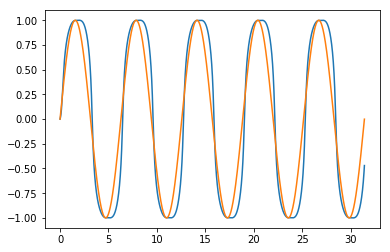

In [9]:
plt.plot(t, (H+M)/np.max(H+M))
plt.plot(t, H/np.max(H))
plt.show()